https://minassaleh.github.io/

## Louisiana Hydrographic Data Analysis
#### Mina Saleh and Ryan Park

### Project Description

Our final project for our data science class this semseter will take a look at studies of Lousiana hydrographic data. Extensive studies have been made to record water data in the region of Lousiana. With access to data recorded by the Coastal Protection and Restoration Authority (CPRA), we can analyze some fundamental attributes pertaining to the water, namely the water level, the water's temperature, and the quality of the water by looking at the pH and salaninty. This data has been collected across a variety of research sites, with several years of recorded data for each. The data is avaialable [here](https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type=hydro_monthly). We will also obtain hourly water level data from the same website.

### Project Plan

We already have a means of scraping the data sources provided by the CPRA. The next step is to isolate some relevant sites and make studies on them. At a foundational level, our program will record the desired hydrographic variables (water level, temperature, and quality) versus time. We can use visuals to survey various trends, and make more complex rate analysis later. For example, how is the rate of temperature change varying across a period of five years? Moreso, with the location of the measurement sites specified, we could link intresting results to local industrial endeavours. Furthermore, the CPRA has made signifcant endeavours to counter the threat of growing land erosion, available here: https://cims.coastal.louisiana.gov/outreach/projects/OPL_Full_page.html. With the data we have, we can attempt to understand the impact of each project. Ultimately, This project aims to use what we are learning throughout the class to provide an overview of the local water situation in the Lousiana area with the help of sensory data gathered by the CPRA. Our aim is to provide a more accessible overview of the fundamental data they have exracted, and then draw our own insight based on what we have. One possible goal of this project would be to make a recommendation to the local glass recycling organization, Glass Half Full Nola, who are interested in depositing recycled sand as a means to restore barrier islands that protect the mainland from storm surge and other storm related disasters. Where is the most useful place to deposit GHF sand? What size should the sand particles be? Are there places where it would be a bad idea to dump sand, and instead better to plant seeds?

In regards to our collaboration effort so far, we have already set up a private Github repository to update the code. We have met in person severals times to plan out and scope the project. Moving forward we will be meeting in person and on zoom to continuously update the project. 

The data below is monthly hydographic data recorded by the CPRA across a collection of sites, as part of various projects. The data contains various water attributes. For now, we will focus on temperature, elevation, pH, and salinity. The data was difficult to gather at first, since they are only accessible by submitting an e-mail request for each project. This was circumvented by using a bot. With the raw data extracted, the next step was to combine the project csv's into a single csv, and read that as a dataframe. This data frame was cleaned by removing extraneous attributes, replacing empty strings with NaNs, and combining the date and time.  

We have already isolated the table, which has an enormous collection of data, and cleaned it with what we currently intend to use. Moving forward, we will work on isolating several station ID's, and their associated data. We can then use the data we obtain from each station to understand the development of the water situation at that location.

### Imports

In [3]:
import os
from os import listdir as ls
from os.path import join as pjoin
import re
import requests
import time

from bs4 import BeautifulSoup as bs
from fake_useragent import UserAgent
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.proxy import Proxy, ProxyType

### Webscraping

In [22]:
# Get information from CPRA coastal protection authority.
data_type = "biomass" # "hydro_monthly" "accretion"
site = f"https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type={data_type}"
extract = requests.get(site)

In order to access CPRA data, we must submit download requests from the website as the data is not explicitly available from the site. One solution to this problem is to use a chromebot that will visit the CPRA site and execute the requests one at a time at a fast rate. There are roughly 500 downloads that we would like to extract across three datasets

In [34]:
def get_free_proxies():
    """Due to https://stackoverflow.com/questions/59409418/how-to-rotate-selenium-webrowser-ip-address"""
    driver = webdriver.Chrome()
    driver.get('https://sslproxies.org')
    table = driver.find_element(By.TAG_NAME, 'table')
    thead = table.find_element(By.TAG_NAME, 'thead').find_elements(By.TAG_NAME, 'th')
    tbody = table.find_element(By.TAG_NAME, 'tbody').find_elements(By.TAG_NAME, 'tr')
    headers = [th.text.strip() for th in thead]
    proxies = []
    for tr in tbody:
        proxy_data = {}
        tds = tr.find_elements(By.TAG_NAME, 'td')
        for i in range(len(headers)):
            proxy_data[headers[i]] = tds[i].text.strip()
        proxies.append(proxy_data)
    driver.close()
    return [f"{pr['IP Address']}:{pr['Port']}" for pr in proxies]


def setup_driver(ip=None, random_user=False):
    driver_specs = {"options": Options()}
            
    if ip:
        # Rotating proxy
        prox = Proxy()
        prox.proxy_type = ProxyType.MANUAL
        prox.http_proxy = ip
        capabilities = webdriver.DesiredCapabilities.CHROME
        prox.add_to_capabilities(capabilities)
        driver_specs["desired_capabilities"] = capabilities
    if random_user:
        # Rotating user-agent
        driver_specs["options"].add_argument(
            f"user-agent={UserAgent().random}")
    return webdriver.Chrome(**driver_specs)
    
           
def chrome_bot(site, site_text, rotate_ip=False):
    email = "rpark1@tulane.edu"
    # Get the name of each project for field extract
    projects = re.findall("[A-Z]{2}-[0-9]{4}[\ -].*\)", site_text) # \([0-9]{2}/.*\)
    # Optional Start condition
    # projects = projects[projects.index("LA-0206 - HSDRRS ARMORING (10/20/2011 to 03/25/2021 [225])"):]
    for p in projects:
        # Start chrome bot.
        driver = setup_driver()
        # Go to CPRA.
        driver.get(site)
        # Check off for long/lat data
        driver.find_element_by_id("MainContent_CB_StationLatLong").click()
        # Select project.
        driver.find_element_by_id("MainContent_DDL_ProjectList").send_keys(p)
        # Press download
        driver.find_element_by_id("MainContent_BTN_DownLoad").click()
        try:
            # File small enough to auto extract.
            # Name the extract file
            driver.find_element_by_id("MainContent_TB_Filename").send_keys(p.split()[0])
            # Submit extraction 
            driver.find_element_by_id("MainContent_BTN_OkFilename").click()
        except:
            # Otherwise must go through email.
            driver.find_element_by_id("MainContent_TB_OkCancelEmailInfo").send_keys(email)
            # Submit
            driver.find_element_by_id("MainContent_BTN_OkCancelEmailOk").click()
        # Close for next request.
        time.sleep(1.1)
        driver.close()

# Download each project found on the website locally, named into zip files after each project
# Note: some of these zip files are too big and get emailed to the email specified in chrome_bot
# chrome_bot(site, extract.text)

The code above takes about 20 minutes to download the each of the projects any of the websites. Occasionally the bot will crash about half way through, in which case line 43 can be uncommented with the appropriate index query to start where the bot left off. An email must be supplied for files that are too large to download straight from the internet. The bot will have those files sent to the email specified in line 39. Once all emails are sent, files are downloaded from the email and then renamed to the project code prefix. Unzipping all the downloaded results in a set of csv files that are assembled into folders corresponding to each dataset.

### Assembly and Tidying

In [36]:
# After unzipping and renaming emailed files, we are left with csv files. We would like to combine these
# into dataframes, and rewrite tidy data back to the disk for later loading.

def combine_from_zip(name, blacklist=[]):
    # Concatonate csv files and create project column.
    # My data location currently # TODO: decide on dir structure in github.
    df = pd.DataFrame()
    dat_path = pjoin("..", "data", name)
    # data from storage
    for f in ls(dat_path):
        # print(f)
        # Skip non csv.
        if ".csv" not in f or f in blacklist:
            continue
        fpath = pjoin(dat_path, f)
        subdf = pd.read_csv(fpath, encoding="latin1")
        df = df.append(subdf)
    return df

# hydro_untidy = combine_from_zip("CPRA_Hydro_Monthly")
# accretion_untidy = combine_from_zip("CPRA_Accretion", blacklist=["BS-0019.csv", "BS-0026.csv", "BS-0008.csv", "BA-0158.csv", "BA-0159.csv"])
# biomass_untidy = combine_from_zip("CPRA_Biomass")
# Blacklisted data has an extra column, might reformat those files later,

#### Tidying Hydrographic Data

In [40]:
# Focus on only the columns we care about
cols = ["CPRA Station ID", "Date (mm/dd/yyyy)", "Time (hh:mm)", "Measurement Depth (ft)",
        "Staff Gauge (ft)", "Water Temperature (°C)", "Specific Conductance (uS/cm)",
        "Salinity (ppt)", "pH (pH units)", "Latitude", "Longitude"]
# print(hydro["Time Zone"].unique()) # all CST
hydro_subset = hydro_untidy[cols].copy()
# Create datetime columns
hydro_subset.loc[:, "Datetime"] = pd.to_datetime(
    hydro_subset["Date (mm/dd/yyyy)"] + "_" + hydro_subset["Time (hh:mm)"],
    format="%m/%d/%Y_%H:%M")
hydro = hydro_subset.drop(["Time (hh:mm)", "Date (mm/dd/yyyy)"], axis=1)
hydro

,CPRA Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),pH (pH units),Latitude,Longitude,Datetime
0,CRMS6304-P01,0.328,0.67,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00
1,CRMS6304-P01,0.328,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
2,CRMS6304-P01,0.984,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
3,CRMS6304-P01,0.328,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
4,CRMS6304-P01,0.984,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
...,...,...,...,...,...,...,...,...,...,...
879,CRMS0261-V51,0.984,NaN,NaN,NaN,NaN,NaN,29.601989,-90.104419,2018-08-07 11:23:00
880,CRMS0261-V51,0.328,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00
881,CRMS0261-V51,0.984,0.56,NaN,NaN,NaN,NaN,29.601989,-90.104419,2019-08-20 13:06:00
882,CRMS0261-V51,0.328,1.58,NaN,NaN,NaN,NaN,29.601989,-90.104419,2021-08-19 13:25:00


#### Tidying Accretion Data

In [ ]:
# UNFINISHED
# Observe the dataset columns
accretion_untidy.columns
# Focus on only the columns we care about
cols = ["Latitude", "Longitude"]
accretion_subset = accretion_untidy[cols]
# Create datetime columns
accretion_subset.loc[:, "Datetime"] = pd.to_datetime(
    accretion_subset["Date (mm/dd/yyyy)"] + "_" + accretion_subset["Time (hh:mm)"],
    format="%m/%d/%Y_%H:%M")
accretion = accretion_untidy.drop(["Time (hh:mm)", "Date (mm/dd/yyyy)"], axis=1)

#### Tidying Biomass Data

In [62]:
# UNFINISHED

### Load Checkpoint

In [41]:
# Save tidy data up to this point
write = False
if write:
    hydro.to_csv("../data/hydro.csv")

# Read in processed df from cell above
hydro=pd.read_csv("../data/hydro.csv", index_col=0)
# Recover datetimes
hydro.loc[:, "Datetime"] = pd.to_datetime(hydro.Datetime)
hydro.head()

,CPRA Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),pH (pH units),Latitude,Longitude,Datetime
0,CRMS6304-P01,0.328,0.67,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00
1,CRMS6304-P01,0.328,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
2,CRMS6304-P01,0.984,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
3,CRMS6304-P01,0.328,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
4,CRMS6304-P01,0.984,1.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00


### Site Locations
We will start by mapping out the sites on a map of Louisiana

Text(0.5, 1, 'Lousiana site study locations')

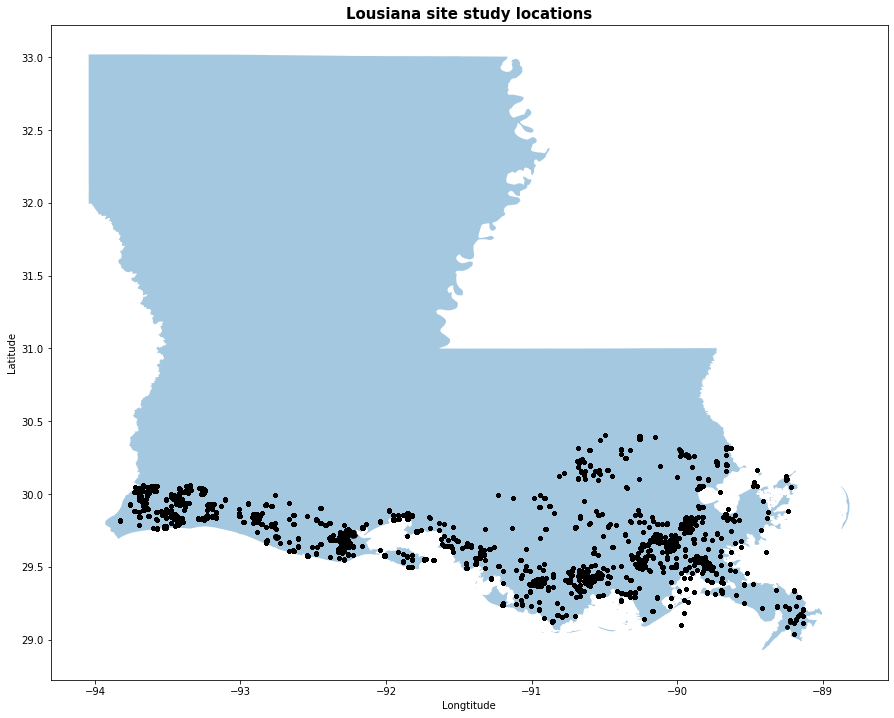

In [42]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
states = gpd.read_file("cb_2017_us_state_500k")
type(states)
geometry = [Point(xy) for xy in zip(hydro["Longitude"], hydro["Latitude"])]
geo_df = gpd.GeoDataFrame(hydro,geometry = geometry)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlabel("Longtitude")
ax.set_ylabel("Latitude")
states[states['NAME'] == 'Louisiana'].plot(ax=ax, alpha=0.4)
geo_df.plot(ax=ax, alpha=0.5, legend=True, markersize=10, c="black")
plt.title("Lousiana site study locations", fontsize=15,fontweight="bold");

### Exploratory Data Analysis: Hydrographic Variance
Since our project plans to recommend the best possible erosion protection strategy per water research site, we will start by looking at how varied the sites we are looking at actually are. 

We will first take a look at the staff gauge. Staff gauges signify how deep the water level at a particular site are. Having staff gauge data can be useful for identifying the water level development at a particular site. Additionally, as used below, examining the stagg gauge records can be useful for developing a preliminary idea on the uniformity of protection measures. 

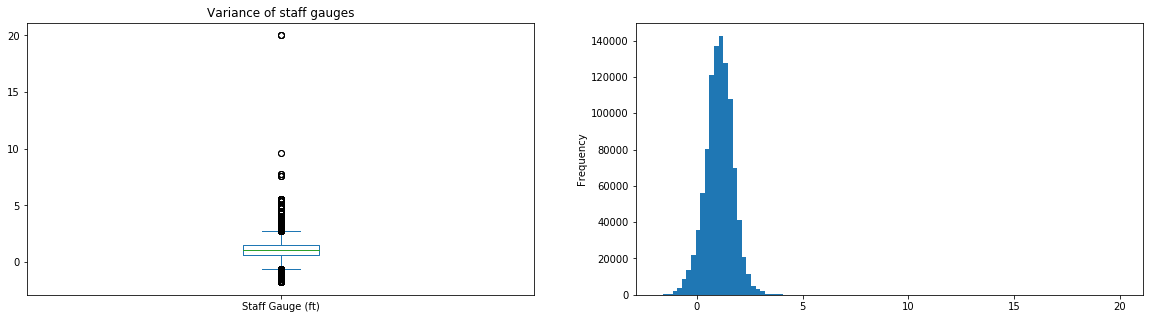

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
hydro["Staff Gauge (ft)"].plot.box(ax = ax[0], title="Variance of staff gauges")
hydro["Staff Gauge (ft)"].plot.hist(bins = 100);

Let's apply a similar sort of analysis to each of the pH and salinity. The water's pH will not necassarily make a difference in how suceptible an area is to flooding, or erosion, but can impact the choice of protection strategy. 

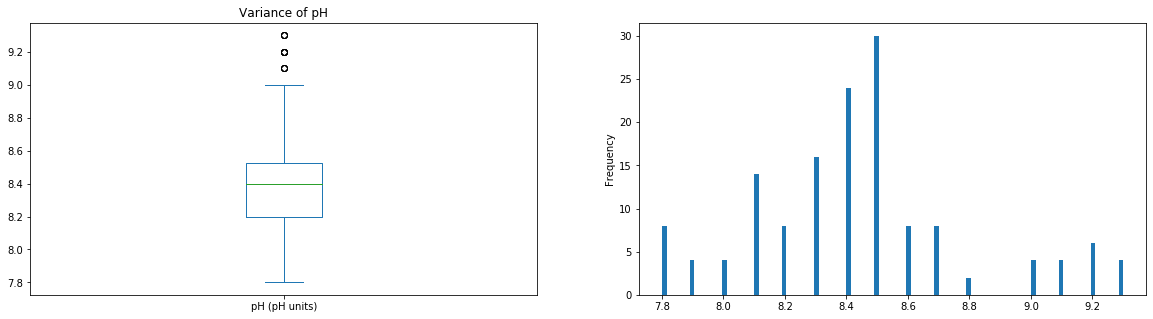

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
hydro["pH (pH units)"].plot.box(ax = ax[0], title="Variance of pH")
hydro["pH (pH units)"].plot.hist(bins = 100);

Here's another very similat test for salinity. We expect this may be another factor in the ability of a region to host vegetative growth after a long period of time.

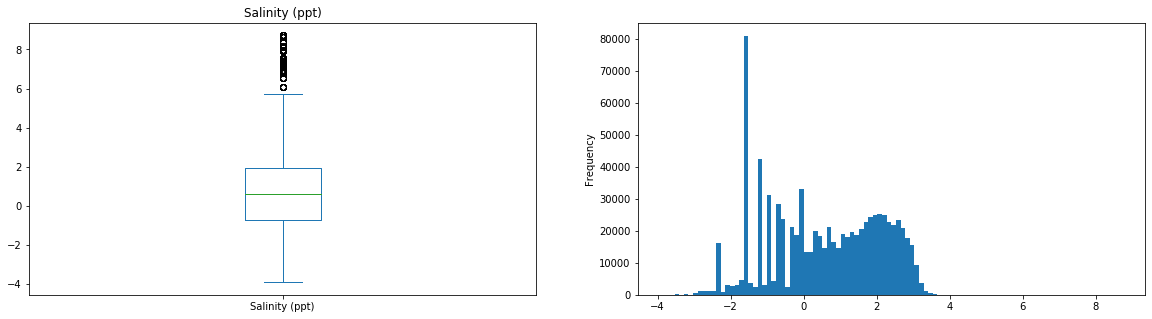

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
hydro[hydro["Salinity (ppt)"] > 0]["Salinity (ppt)"].map(np.log).plot.box(ax = ax[0], title="Salinity (ppt)")
hydro[hydro["Salinity (ppt)"] > 0]["Salinity (ppt)"].map(np.log).plot.hist(bins = 100);

Here we observe the log transform of the data, lest we are unable to see the finer detail of all the data between 1e-3 and 1e4 ppt.

### Exploratory Data Analysis: Vegetation

One of the most cost effective ways to mitigate the threat of erosion is through the effective use of vegetation. That's right, gardening can be as much a pastime as it could be a salvation effort for the effort. 

Plant roots can sturdy the structure of the sand, and reduce the risk of erosion. Plants typically thrive at PH between a PH of 5 and 7. None of our sites have that, but fortunately some varieties can grow at PH's as high as 8.5, which qualifies a good number of the sites, albeit tenuously. Let's take a look. 

In [52]:
hydro=hydro.rename(columns={"pH (pH units)" : "pH"})
UniqueStations=(pd.unique(hydro["CPRA Station ID"]))
PhEligible=hydro[hydro.pH<8.6]
PhStations=pd.unique(PhEligible["CPRA Station ID"])

print(len(PhStations)/len(PhEligible))
print(PhStations)

0.1111111111111111
['BA-WQ-TS1-01' 'BA-WQ-TS1-02' 'BA-WQ-TS1-03' 'BA-WQ-TS2-01'
 'BA-WQ-TS2-02' 'BA-WQ-TS2-03' 'BA-WQ-TS4-01' 'BA-WQ-TS4-02'
 'BA-WQ-TS4-03' 'BA-WQ-TS6-01' 'BA-WQ-TS6-02' 'BA-WQ-TS6-03']


11% of the stations were eligible. That's discouraging, but let's try plotting on them a map. 

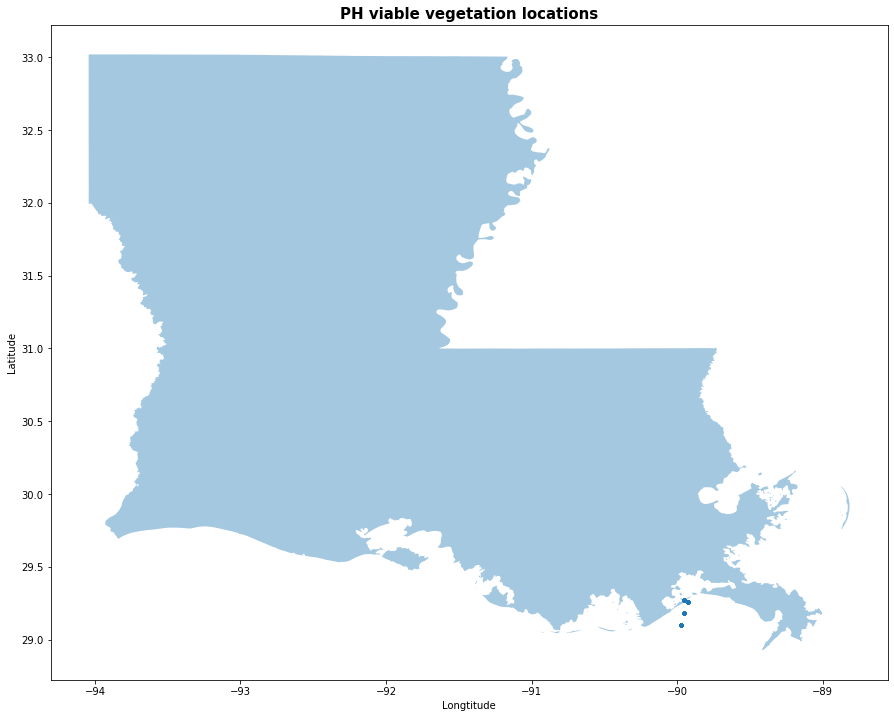

In [55]:

geometry = [Point(xy) for xy in zip(PhEligible["Longitude"], PhEligible["Latitude"])]
geo_df = gpd.GeoDataFrame(PhEligible,geometry = geometry)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlabel("Longtitude")
ax.set_ylabel("Latitude")
states[states['NAME'] == 'Louisiana'].plot(ax=ax, alpha=0.4)
geo_df.plot(ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title("PH viable vegetation locations", fontsize=15,fontweight="bold");

There were 12 unique sites,but only 4 points on the map. It could be surmised that these each sites had three recordings in approximately the same location, thereby overlapping on the map.  
Here are the site recordings in dataframe form

In [57]:
display(PhEligible)

,CPRA Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),pH,Latitude,Longitude,Datetime,geometry
0,BA-WQ-TS1-01,1.640,NaN,29.5,40211.7,25.6,8.3,29.274000,-89.954500,2018-07-25 12:25:00,POINT (-89.95450 29.27400)
1,BA-WQ-TS1-01,3.280,NaN,29.4,26066.0,15.9,8.5,29.274000,-89.954500,2018-09-26 09:53:00,POINT (-89.95450 29.27400)
2,BA-WQ-TS1-01,1.640,NaN,19.1,16827.5,9.9,8.5,29.274000,-89.954500,2019-03-26 12:00:00,POINT (-89.95450 29.27400)
3,BA-WQ-TS1-01,3.280,NaN,27.6,26890.4,11.8,8.5,29.274000,-89.954500,2019-05-21 11:48:00,POINT (-89.95450 29.27400)
5,BA-WQ-TS1-01,3.280,NaN,30.9,29081.1,15.8,8.4,29.274000,-89.954500,2019-08-29 12:59:00,POINT (-89.95450 29.27400)
...,...,...,...,...,...,...,...,...,...,...,...
67,BA-WQ-TS6-03,55.774,NaN,29.4,50097.5,32.8,8.2,29.101671,-89.972003,2018-09-26 08:28:00,POINT (-89.97200 29.10167)
68,BA-WQ-TS6-03,49.212,NaN,20.7,50235.0,31.6,8.0,29.101671,-89.972003,2019-03-26 09:00:00,POINT (-89.97200 29.10167)
69,BA-WQ-TS6-03,59.055,NaN,23.8,57170.7,39.1,8.1,29.101671,-89.972003,2019-05-21 09:05:00,POINT (-89.97200 29.10167)
70,BA-WQ-TS6-03,57.414,NaN,25.6,54102.5,35.4,8.5,29.101671,-89.972003,2019-07-25 09:55:00,POINT (-89.97200 29.10167)


After determining viable stations for growing vegetation, we can measure their "distance from an optimal location". For our purposes, this optimal location will have a pH of 6, and a salinity (how much salt is in the water) of zero. 

In [58]:
PhD=PhEligible[["CPRA Station ID","pH", "Salinity (ppt)"]]
PhD = PhD.append({'CPRA Station ID': 'Placeholder', "pH":7,"Salinity (ppt)":0 }, ignore_index=True)
display(PhD)

,CPRA Station ID,pH,Salinity (ppt)
0,BA-WQ-TS1-01,8.3,25.6
1,BA-WQ-TS1-01,8.5,15.9
2,BA-WQ-TS1-01,8.5,9.9
3,BA-WQ-TS1-01,8.5,11.8
4,BA-WQ-TS1-01,8.4,15.8
...,...,...,...
104,BA-WQ-TS6-03,8.0,31.6
105,BA-WQ-TS6-03,8.1,39.1
106,BA-WQ-TS6-03,8.5,35.4
107,BA-WQ-TS6-03,8.0,32.8


You will notice that the each station has more than one measurement associated with, that's because these measurements were made over time. Let's take the average for each station. 

In [59]:
AvPh=PhD.groupby('CPRA Station ID')["pH"].mean()
display(AvPh)
AvS=PhD.groupby('CPRA Station ID')["Salinity (ppt)"].mean()
data ={'CPRA Station ID':PhD["CPRA Station ID"],'Average pH': AvPh, 'Average Silinity (ppt)':AvS}
UpdatedPh = pd.concat([AvPh, AvS],axis=1)
display(UpdatedPh)

CPRA Station ID
BA-WQ-TS1-01    8.440000
BA-WQ-TS1-02    8.400000
BA-WQ-TS1-03    8.400000
BA-WQ-TS2-01    8.400000
BA-WQ-TS2-02    8.425000
BA-WQ-TS2-03    8.380000
BA-WQ-TS4-01    8.400000
BA-WQ-TS4-02    8.150000
BA-WQ-TS4-03    8.000000
BA-WQ-TS6-01    8.300000
BA-WQ-TS6-02    8.160000
BA-WQ-TS6-03    8.116667
Placeholder     7.000000
Name: pH, dtype: float64

,pH,Salinity (ppt)
CPRA Station ID,,
BA-WQ-TS1-01,8.440000,15.800000
BA-WQ-TS1-02,8.400000,16.260000
BA-WQ-TS1-03,8.400000,17.160000
BA-WQ-TS2-01,8.400000,16.100000
BA-WQ-TS2-02,8.425000,16.650000
BA-WQ-TS2-03,8.380000,18.760000
BA-WQ-TS4-01,8.400000,20.833333
BA-WQ-TS4-02,8.150000,29.750000
BA-WQ-TS4-03,8.000000,32.800000


We finally have a table withthe average pH's and salinities for each site. Let's finally examine their distance from the Placeholder (the optimal location) after standerizing the above table.

In [61]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
UpdatedPh_ = (
    (UpdatedPh - UpdatedPh.mean()) / 
    UpdatedPh.std())

UpdatedPh_['Distance from optimal'] = euclidean_distances(UpdatedPh_, UpdatedPh_.to_numpy()[12,None]).squeeze()
UpdatedPh_.drop( index="Placeholder", inplace=True)
UpdatedPh_ = UpdatedPh_.sort_values(by=['Distance from optimal'])
display(UpdatedPh_)

,pH,Salinity (ppt),Distance from optimal
CPRA Station ID,,,
BA-WQ-TS2-01,0.521792,-0.510552,4.005475
BA-WQ-TS1-02,0.521792,-0.493371,4.012921
BA-WQ-TS1-03,0.521792,-0.396729,4.055903
BA-WQ-TS1-01,0.625026,-0.542766,4.085357
BA-WQ-TS2-02,0.586313,-0.451493,4.089247
BA-WQ-TS2-03,0.470175,-0.224920,4.091784
BA-WQ-TS6-01,0.263709,0.126571,4.105400
BA-WQ-TS4-01,0.521792,-0.002285,4.249655
BA-WQ-TS4-02,-0.123417,0.955189,4.360508


We know have a general idea of the locations that are potentially viable for erosion protection through growing vegeation! In the furute we hope to add more metrics that might span a larger range of the coast. We can then expand this same strategy to other variables easily.

### Model Predictions

One of the best ways of combatting land erosion from wind and water is to plant vegetation near the coast. Plant roots spread through the sand making it more resilient against erosion, and above-ground vegitation encourages natural dune formation. Newly planted material often takes an entire season to establish itself and its protective effects are cumulative but slow. Sometimes it is necessary to take more immediate action into protecting the coast, such as the use of sandbags, man made dunes, or sea walls. Sea walls can often be difficult to maintain, as with sandbags, and these methods typically prevent futher vegitative growth in the area. Even man-made sand dunes lack the continuous density gradient that natural sands have which encourages plant-root growth. For these reasons we would like to use hydrographic, vegitation, and accretion data in order to classify regions of the coast as best being protected by one of the above methods.

To do this we will identify the hydrographic conditions that afford vegetative growth, search for locations that have little vegetation but the opportunity to grow more, and determine if active planting will be a good solution for that area. Alternatively, if the hydrographic conditions are not condusive to plant growth, we may classify that region as being best protected by unnatural sand formations.

As a secondary part of our model, we would like to use accretion data see how the coast is evolving overtime. If we could calculate how quickly the coastline is receeding in certain areas, then we could determine an "urgency" metric and rule out certain regions of the coast from viably being protected with plants. We may try to obtain population location data to try to determine weights to how urgent erosion prevention is in certain places across the coast.